In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyelsa as elsa
from reconstruction import XrayOperator, rebin_fan2par, fbp_fan, bpf_fan
from skimage.transform import radon, iradon,rescale

pyelsa not build with CUDA projector support


### 1. Filter-backproject (FBP) approach for 360$^{\circ}$ scans (equidistant case/ flat detector)

Forward projection (Reminder):
\begin{equation}
    p(s,\beta) = \int_{L(s,\beta)} f(x, y) \ d\ell 
    = \iint f(x, y) \delta( x\cos\phi(s.\beta) + y\sin\phi(s.\beta) - r(s)) \,dx\,dy
\end{equation}

[2024-01-06 11:23:06.855] [phantom::modifiedSheppLogan] [info] creating modified Shepp Logan phantom of size 128^2
[2024-01-06 11:23:06.863] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 420 poses in an 360 degree arc
[2024-01-06 11:23:06.869] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 420 poses in an 360 degree arc


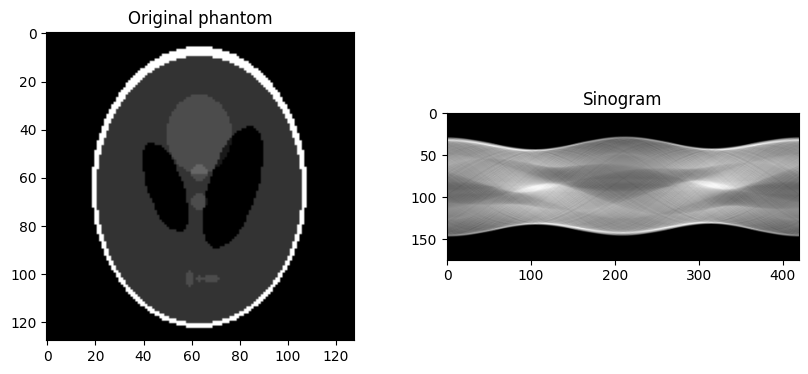

In [3]:
# Step 1: setup the sinogram
size = np.array([128, 128])
phantom = np.rot90(elsa.phantoms.modifiedSheppLogan(size), -1)

num_angles = 420 # number of projections
arc = 360   # Full view

s2c = size[0] * 100 # distance from the X-ray source to isocenter 
c2d = size[0]       # distance from isocenter to detector
sd = s2c + c2d      # distance from X-ray source to detector

# Create the sinogram
projector0 = XrayOperator.XrayOperator(size, [180], np.linspace(0, arc, num_angles), s2c, c2d)
projector1 = fbp_fan.Fbp_fan(size, [175], np.linspace(0, arc, num_angles), s2c, c2d, cor_offset=[0,0],pp_offset=[0])
sino0 = projector0.apply(phantom)
sino1 = projector1.apply(phantom)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("Original phantom")
ax1.imshow(phantom, cmap="gray")

ax2.set_title("Sinogram")
ax2.imshow(sino1, cmap="gray")

plt.show()

FBP algorithm for fan beam tomography (Reminder!!)

Step 1. Compute weighted projections for each ${\beta}$.

\begin{equation}
    \overline{p}(s,\beta) =  p(s,\beta) \frac{w_{2\pi} (s,\beta)J(s)}{W_{1}^2(s)} 
\end{equation}

\begin{equation}
    w_{2\pi}(s,\beta)\frac{J(s)}{W_{1}^2(s)} =  \frac{w_{2\pi}(s,\beta)}{D_{sd}} \lvert D_{so} \cos{\gamma(s)} - r_{off} \sin{\gamma(s)} \approx w_{2\pi}(s,\beta) \frac{D_{so}}{\sqrt{D_{sd}^2+s^2}}
\end{equation}

\begin{equation}
    \gamma(s) = \arctan(\frac{s}{D_{sd}})
\end{equation}

Step 2. Filter those weighted projections (along s) for each ${\beta}$ using the modified ramp filter

\begin{equation}
    \overline{p}(s,\beta) =   \overline{p}(s,\beta) * g_{s}(s)
\end{equation}

\begin{equation}
h[n] =
\left\{
	\begin{array}{ll}
		1,  & n=0 \\
		0 ,  & \text{n even } \\
            \frac{-1}{(\pi n/2)^2 } ,  & \text{n odd } 
	\end{array}
\right.
\end{equation}

Step 3. Perform a weighted backprojection of those filtered projections: 

\begin{equation}
    f(x,y) =   \int_{0}^{2\pi} \frac{1}{W_{2}^2(x,y,\beta)L_{\beta}^2(x,y)}  \overline{p}(s_{\beta}(x,y),\beta) d\beta
\end{equation}

\begin{equation}
    \frac{1}{W_{2}^2 L_{\beta}^2(x,y)} =  \frac{D_{sd}^2}{(\cos \gamma_{\beta}(x,y) L_{\beta}(x,y))^2} = \frac{D_{sd}^2}{(D_{s0}-y_{\beta})^2}
\end{equation}

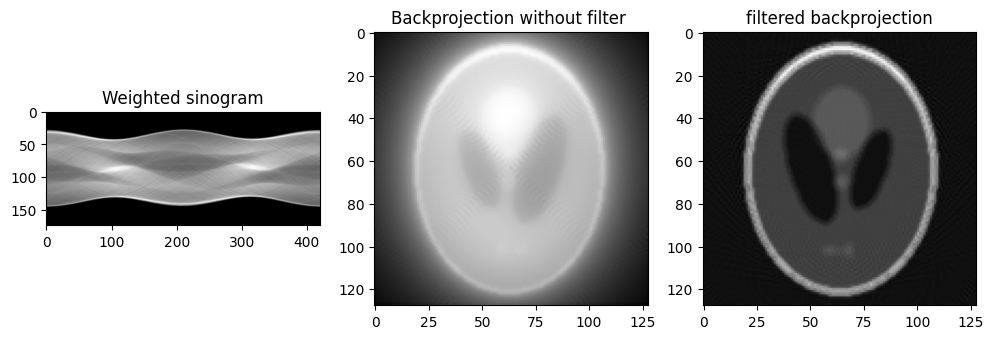

In [3]:
# Now lets backproject the image and compare the reconstructed image with the original phantom above, concreate implementation in fbp_fan.py
img0 = projector0.applyAdjoint(sino0)
img1, saved_img1, wsino1 = projector1.applyAdjoint(sino1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.set_title("Weighted sinogram")
ax1.imshow(wsino1, cmap="gray")

ax2.set_title("Backprojection without filter ")
ax2.imshow(img0, cmap="gray")

ax3.set_title("filtered backprojection")
ax3.imshow(img1.T, cmap="gray")


Lets looks at the intermediate backprojection steps for the FBP method

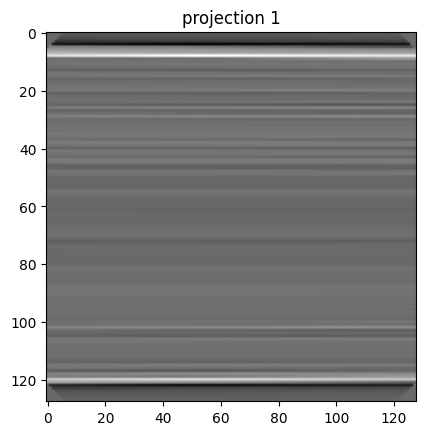

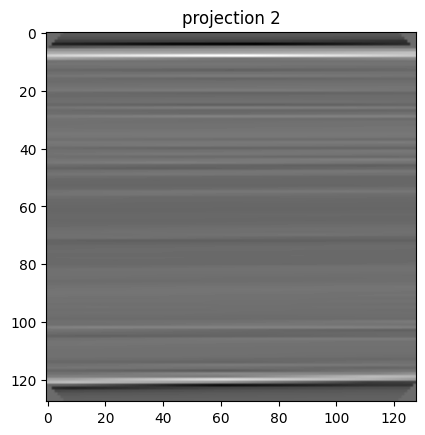

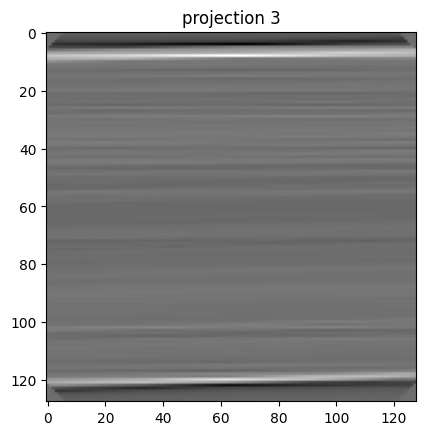

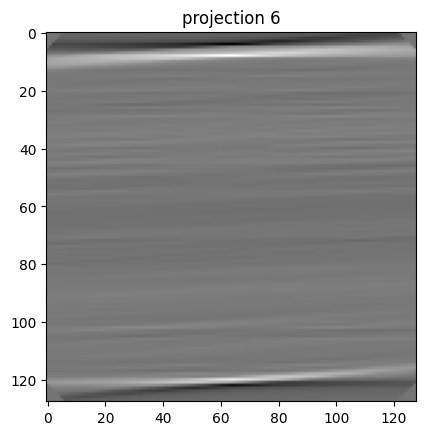

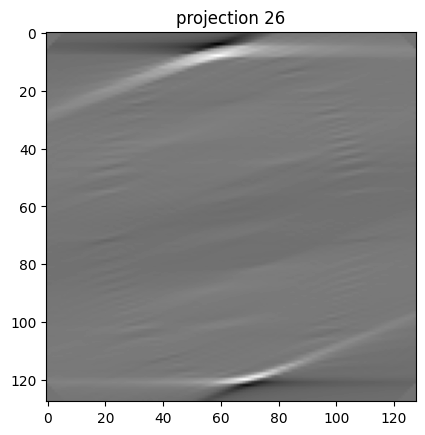

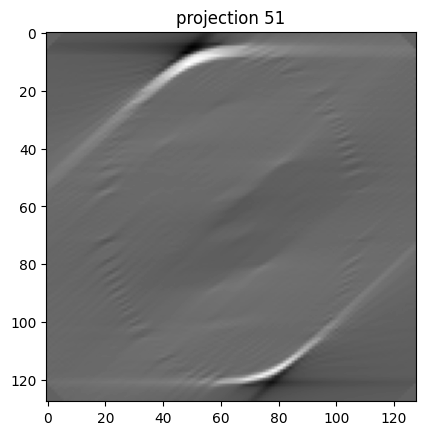

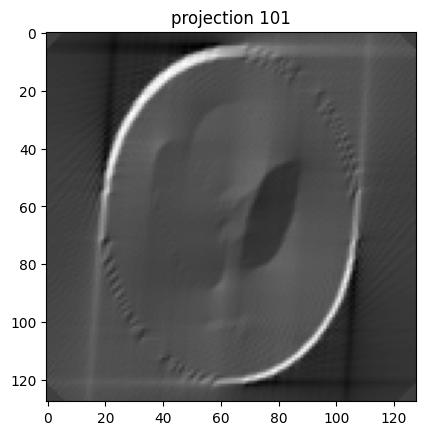

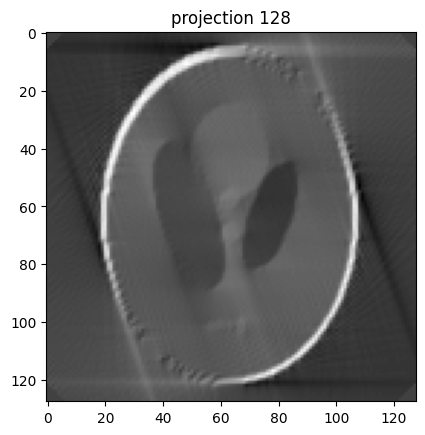

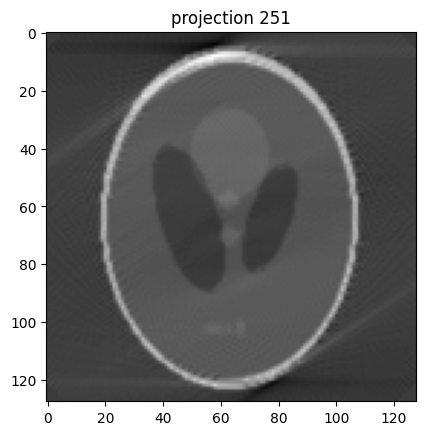

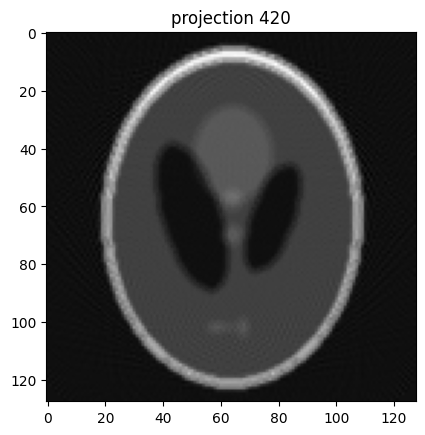

In [12]:
show_img = [0,1,2,5,25,50,100,127,250,419] # pick the index of backprojected image to be shown
for i in show_img:
    im = saved_img1[i]
    plt.imshow(im.T, cmap='gray') 
    plt.title("projection {}".format(i+1))
    plt.show()


### 2. FBP for short scans (<360$^{\circ}$)

Parker weight (Reminder !!):

\begin{equation}
w_{2\pi}(s,\beta) =
\left\{
	\begin{array}{ll}
		q(\frac{\beta}{2(\gamma_{max}-\gamma)}),  & 0\le\beta\le2(\gamma_{max}-\gamma) \\
		1 ,  & 2(\gamma_{max}-\gamma)<\beta<\pi-2\gamma  \\
            q(\frac{\pi+2\gamma_{max}-\beta}{2(\gamma_{max}+\gamma)}) ,  & \pi-2\gamma\le\beta\le\pi+2\gamma_{max}
	\end{array}
\right.
\end{equation}

where $q(x)=\sin^2 (\frac{\pi}{2}x)$ and $\gamma_{max}=\gamma(s_{max)}$ and $s_{max}$ is half of the total arc length of the detector


[2024-01-05 18:23:26.701] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 180 poses in an 128 degree arc
parker weight used


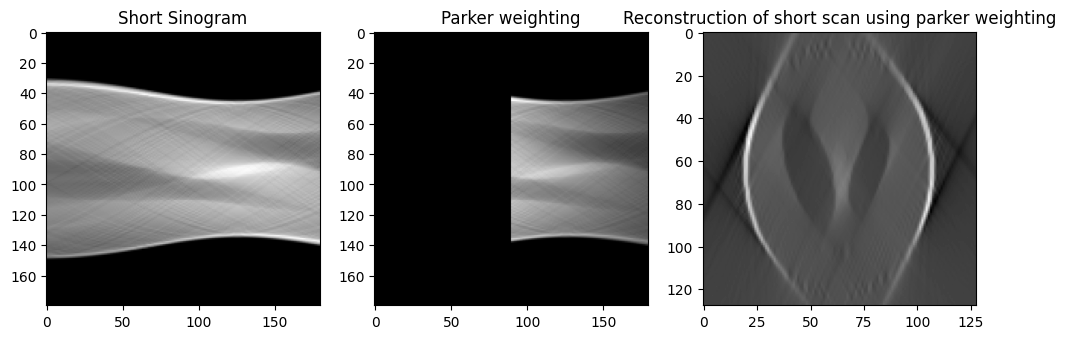

In [3]:
num_angles = 180
arc = 128

s2c = size[0] * 100
c2d = size[0] 
sd = s2c + c2d

projector2 = fbp_fan.Fbp_fan(size, [180], np.linspace(0, arc, num_angles), s2c, c2d, cor_offset=[0,0],pp_offset=[0],weighting="parker")
sino2 = projector2.apply(phantom)
img2, saved_img2, wsino2 = projector2.applyAdjoint(sino2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.set_title("Short Sinogram")
ax1.imshow(sino2, cmap="gray")

ax2.set_title("Parker weighting")
ax2.imshow(wsino2, cmap="gray")

ax3.set_title("Reconstruction of short scan using parker weighting")
ax3.imshow(img2.T, cmap="gray")

plt.show()


### 3. Backproject-filter (BPF) approach

\begin{equation}
    b(x,y) = = \int_{-s_{max}}^{s_{max}} \int_{0}^{\beta_{max}}  \delta( x\cos\phi(s.\beta) + y\sin\phi(s.\beta) - r(s)) w_{BPF}(s,\beta) \,ds\,d\beta
\end{equation}

[2024-01-05 09:43:26.199] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 420 poses in an 360 degree arc


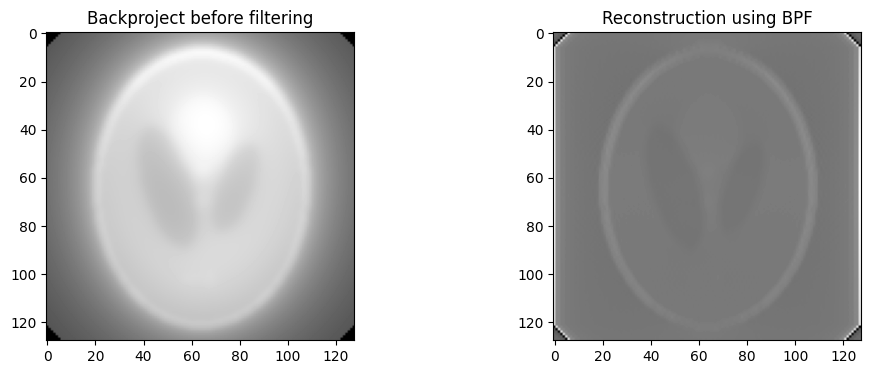

In [20]:
# Create a backprojection filter projector object
num_angles = 420 # number of projections
arc = 360   # Full view

s2c = size[0] * 100 # distance from the X-ray source to isocenter 
c2d = size[0]       # distance from isocenter to detector
sd = s2c + c2d      # distance from X-ray source to detector

projector3 = bpf_fan.Bpf_fan(size, [185], np.linspace(0, arc, num_angles), s2c, c2d, cor_offset=[0,0],pp_offset=[0])
sino3 = projector1.apply(phantom)
img3, unfiltered_img3  = projector3.applyAdjoint(sino3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))


ax1.set_title("Backproject before filtering")
ax1.imshow(unfiltered_img3.T, cmap="gray")

ax2.set_title("Reconstruction using BPF")
ax2.imshow(img3.T, cmap="gray")

plt.show()

### 4. Fan-parallel rebinning methods
(i) angular interpolation - $\phi=\beta+\gamma$ \
(ii) radial interpolation - $r=D\sin\gamma$


[2024-01-05 10:16:44.655] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 128 poses in an 360 degree arc


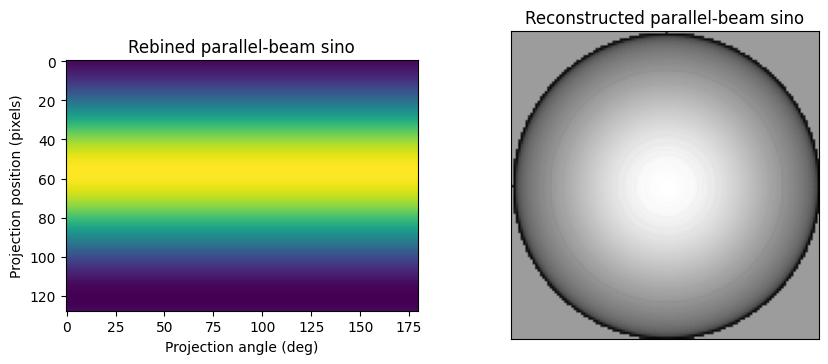

In [47]:
num_angles = 128
arc = 360

s2c = size[0] * 100
c2d = size[0] 
sd = s2c + c2d

projector4 = rebin_fan2par.RebinFan2Par(size, [180], np.linspace(0, arc, num_angles), s2c, c2d, cor_offset=[0,0],pp_offset=[0])
sino4 = projector4.apply(phantom)

psino = projector4.rebin_fan2par(sino4)
recon = iradon(psino[:,:,0].T, np.linspace(0, arc, 180))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(psino[:,:,0].T)
ax1.set_title("Rebined parallel-beam sino")
ax1.set_xlabel("Projection angle (deg)")
ax1.set_ylabel("Projection position (pixels)")

ax2.imshow(recon, cmap="gray")
ax2.set_title("Reconstructed parallel-beam sino")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)